In [26]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import os

image_path = '/media/szelesteya/F824D4D024D492CC/INBReast/inbreast-deprocessed/images'
crop_size = [224, 224]

In [43]:
def crop_black_part(image_array):
    # Cropping every column that doesn't contain tissue
    not_dark = np.where(image_array != 0, 1, 0)
    tissue_distrib_x = np.sum(not_dark, axis=0) / not_dark.shape[0]
    tissue_distri_y = np.sum(not_dark, axis=1) / not_dark.shape[1]
    is_tissue_x = np.where(tissue_distrib_x > 0.1, 1, 0)
    is_tissue_y = np.where(tissue_distri_y > 0.1, 1, 0)

    first_tissue_x = np.where(is_tissue_x == 1)[0][0]
    last_tissue_x = np.where(is_tissue_x == 1)[-1][-1]
    first_tissue_y = np.where(is_tissue_y == 1)[0][0]
    last_tissue_y = np.where(is_tissue_y == 1)[-1][-1]

    return image_array[first_tissue_y:last_tissue_y,first_tissue_x:last_tissue_x]

def crop_by_numbers(image_array):
    # Cropping every column that doesn't contain tissue
    not_dark = np.where(image_array != 0, 1, 0)
    tissue_distrib_x = np.sum(not_dark, axis=0) / not_dark.shape[0]
    tissue_distri_y = np.sum(not_dark, axis=1) / not_dark.shape[1]
    is_tissue_x = np.where(tissue_distrib_x > 0.1, 1, 0)
    is_tissue_y = np.where(tissue_distri_y > 0.1, 1, 0)

    first_tissue_x = np.where(is_tissue_x == 1)[0][0]
    last_tissue_x = np.where(is_tissue_x == 1)[-1][-1]
    first_tissue_y = np.where(is_tissue_y == 1)[0][0]
    last_tissue_y = np.where(is_tissue_y == 1)[-1][-1]
    
    x_crops = math.ceil(2 * ((last_tissue_x - first_tissue_x) - (crop_size[1])) / (crop_size[1]))
    y_crops = math.ceil((last_tissue_y - first_tissue_y) / crop_size[0])

    x_diff = (last_tissue_x - first_tissue_x) - (round(tissue_array.shape[1] / 112)) * 112
    y_diff = (last_tissue_y - first_tissue_y) - y_crops * crop_size[0]
    

    if last_tissue_x + x_diff > image_array.shape[1]:
        first_tissue_x = first_tissue_x - x_diff
    else:
        last_tissue_x = last_tissue_x + x_diff

    if last_tissue_y + y_diff > image_array.shape[1]:
        first_tissue_y = first_tissue_y - y_diff
    else:
        last_tissue_y = last_tissue_y + y_diff

    return image_array[first_tissue_y:last_tissue_y,first_tissue_x:last_tissue_x], x_crops, y_crops

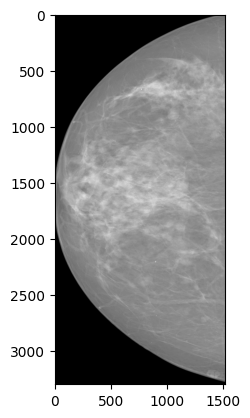

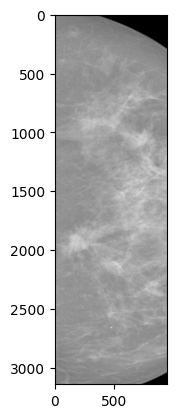

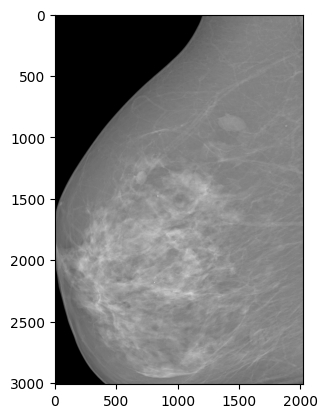

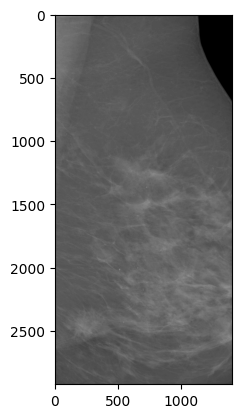

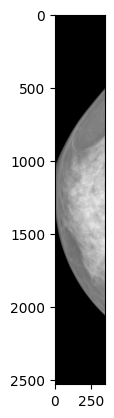

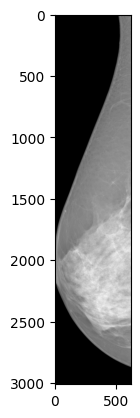

/tmp/ipykernel_16885/2453096041.py:10: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(crop_array, cmap='gray')


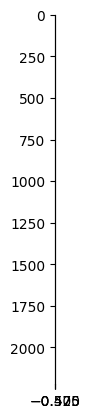

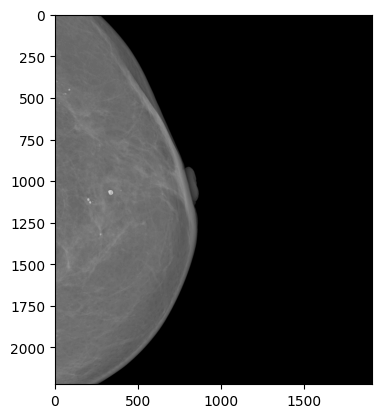

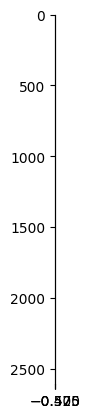

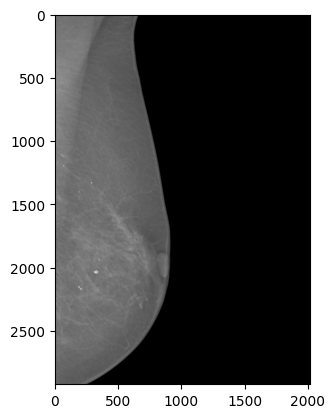

array([[ 28, -60],
       [ 28, -60],
       [ 28, -60],
       [ 28, -60],
       [ 28, -60],
       [ 28, -60],
       [ 28, -60],
       [ 28, -60],
       [ 28, -60],
       [ 28, -60]])

In [44]:
diffs = []

for file in os.listdir(image_path)[0:10]:
    if '.png' in file:
        # Crop picture to equal parts
        image = Image.open(os.path.join(image_path, file))
        image_array = np.array(image)
        crop_array, x_crops, y_crops = crop_by_numbers(image_array)

        plt.imshow(crop_array, cmap='gray')
        plt.show()

        diffs.append([x_diff, y_diff])

diff_array = np.array(diffs)

diff_array

In [34]:
print(np.mean(diff_array, axis=0))

[   0.80684597 -109.19804401]


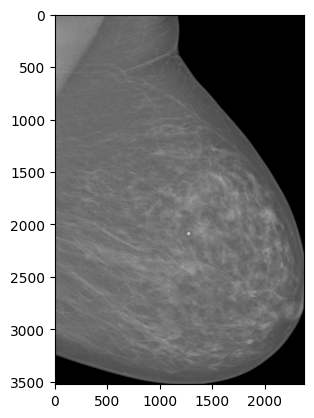

In [35]:
# Crop picture to equal parts
image = Image.open(os.path.join(image_path, file))
image_array = np.array(image)
tissue_array = crop_black_part(image_array)

# Every pixel will be represented two times except the first and last crop_size[1] / 2 pixels of the width
x_crops = math.ceil(2 * (tissue_array.shape[1] - (crop_size[1])) / (crop_size[1]))
y_crops = math.ceil(tissue_array.shape[0] / crop_size[0])

x_diff = tissue_array.shape[1] - (round(tissue_array.shape[1] / 112)) * 112
y_diff = tissue_array.shape[0] - y_crops * crop_size[0]

crop_array = 